<a href="https://colab.research.google.com/github/IFuentesSR/Soil_moisture/blob/main/SM_modelling2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

To obtain access to the datasets used in this work you need to follow the following steps:
* Click on [this](https://drive.google.com/drive/u/1/folders/12cYWIfg_0wATfxxtnnhQfLHrghqazwj6) Google Drive folder link. 

* Then, right click on the **SoilMoisture** folder and select **Add shortcut to Drive**.

![picture](https://drive.google.com/uc?id=1lZqtmeemmmCM7OZUj_kiqDMMvgGS375a)

* Make a shortcut of the **SoilMoisture** folder in your own **My Drive**-folder, by clicking on **Add shortcut**. 

![picture](https://drive.google.com/uc?id=133aXjO2jrfMSj9lzK2aZNq69L6wEiKCH)

A new Google Drive folder with all the contents of this study has been linked to your Google Drive; therefore, we can link our Google Drive account to have access to the data.

# Loading libraries


In [1]:
import os
import numpy as np
import pickle
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
from keras import backend as K
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.layers import Dense, Input, LSTM, Concatenate, Reshape, Lambda, Permute, GRU, SimpleRNN, LayerNormalization, Bidirectional
from tensorflow.keras.activations import relu
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
from tqdm.keras import TqdmCallback
from scipy import stats
import matplotlib.pyplot as plt

enc2 = OneHotEncoder(handle_unknown='ignore')

## Connecting to drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Functions for pre-processing data and modelling

In [107]:
def append_sm2(dataframe, tuple_station):
    '''
    Description: Appends reference soil moistures to predictors dataframe
    Inputs: 
        dataframe: pandas dataframe
        tuple_station: tuple with path to files and name of reference files
    Outputs:
        df: pandas dataframe
    '''
    test = pd.read_csv(tuple_station[0], encoding='latin1')
    cols = test.columns
    test['dates'] = pd.to_datetime(test[cols[0]],
                                    format='%Y-%m-%d %H:%M:%S')
    test = test.set_index('dates')
    test.rename(columns={"0-10": "sm", "0-30": "sm1", "30-60": "sm2"}, inplace=True)
    resampled = test.resample('D').mean()
    resampled['sm'], resampled['sm1'], resampled['sm2'] = resampled['sm']/100, resampled['sm1']/100, resampled['sm2']/100
    df_sampled = dataframe[dataframe['id'].str.lower() == tuple_station[1][6:-4].lower()]
    df_sampledx = df_sampled.copy()
    df_sampledx['soilM'], df_sampledx['soilM1'], df_sampledx['soilM2']  = resampled['sm'], resampled['sm1'], resampled['sm2']
    df_sampledx[(df_sampledx['soilM'] < 0.0) | (df_sampledx['soilM'] > 1)] = np.nan
    df_sampledx[(df_sampledx['soilM1'] < 0.0) | (df_sampledx['soilM1'] > 1)] = np.nan
    df_sampledx[(df_sampledx['soilM2'] < 0.0) | (df_sampledx['soilM2'] > 1)] = np.nan
    df_sampledx[~df_sampledx.index.duplicated(keep='first')]
    df_sampledx = df_sampledx.dropna(subset=['id', 'soilM1', 'soilM2'])
    df_sampledx = df_sampledx.sort_index()
    return df_sampledx


def ccc(y_true, x_true):
    '''
    Description: Creates ccc loss function for tf model
    Inputs: 
        y_true: predictions
        x_true: observations
    Outputs:
        ccc loss function
    '''
    uy, ux = K.mean(y_true), K.mean(x_true)
    sxy = tfp.stats.covariance(y_true, x_true)
    sy, sx = tfp.stats.variance(y_true), tfp.stats.variance(x_true)
    E = 2*sxy/(sy+sx+K.pow(uy-ux, 2))
    return 1-E


def crop(dimension, start, end):
    '''
    Description: Crops (or slices) a Tensor on a given dimension from start to end
    Inputs: 
        start: integer
        end: integger
        dimension: integer with dimensions
    Outputs:
        lambda function
    '''
    def func(x):
        if dimension == 0:
            return x[start: end]
        if dimension == 1:
            return x[:, start: end]
        if dimension == 2:
            return x[:, :, start: end]
        if dimension == 3:
            return x[:, :, :, start: end]
        if dimension == 4:
            return x[:, :, :, :, start: end]
    return Lambda(func)


def mlp2(inputs, lr, decay, epsilon):
    '''
    Description: Creates a MLP tf model
    Inputs: 
        inputs: list of inputs
    Outputs:
        tf model
    '''
    input = Input(shape=(len(inputs)), dtype='float32')
    hidden3 = Dense(100, activation='relu')(input)
    hidden4 = Dense(100, activation='relu')(hidden3)
    hidden5 = Dense(100, activation='relu')(hidden4)
    hidden6 = Dense(50, activation='relu')(hidden5)
    hidden7 = Dense(25, activation='relu')(hidden6)
    mlp_out = Dense(2, activation=lambda x: relu(x, max_value=1.0))(hidden7)

    model = Model(inputs=input, outputs=mlp_out)
    model.compile(loss=ccc, optimizer=Adam(learning_rate=lr, beta_1=0.9, beta_2=0.999, epsilon=epsilon, decay=decay))#0.00003
    return model


def modlx(inputs, lr, decay, epsilon):
    '''
    Description: Creates a combined LSTM and MLP tf model
    Inputs: 
        inputs: list of inputs
        lr: float of learning rate
        decay: float of decay
        epsilon: float for epsilon
    Outputs:
        model: tf model
    '''
    input = Input(shape=(len(inputs), 1), dtype='float32')
    slice1 = crop(1, 0, int(len(lstm_cols)))(input)
    reshaped = Reshape((3, int(len(lstm_cols)/3)), input_shape=(int(len(lstm_cols)), 1))(slice1)
    lstm_input = Permute((2, 1), input_shape=(3, int(len(lstm_cols)/3)))(reshaped)
    hidden1 = Bidirectional(LSTM(50, activation='relu'))(lstm_input)
    hidden1 = LayerNormalization()(hidden1)
    lstm_output = Dense(100, activation='relu')(hidden1)
    slice2 = crop(1, int(len(lstm_cols)), len(var_in))(input)
    slice2 = Reshape((len(var_in) - int(len(lstm_cols)), ),
                     input_shape=(len(var_in) - int(len(lstm_cols)), ))(slice2)
    x = Concatenate()([lstm_output, slice2])
    hidden3 = Dense(128, activation='relu')(x)
    hidden4 = Dense(64, activation='relu')(hidden3)
    hidden5 = Dense(32, activation='relu')(hidden4)
    hidden6 = Dense(16, activation='relu')(hidden5)
    mlp_out = Dense(2, activation=lambda x: relu(x, max_value=1.0))(hidden6)
    model = Model(inputs=input, outputs=mlp_out)
    model.compile(loss=ccc, optimizer=Adam(learning_rate=lr, beta_1=0.9, beta_2=0.999, epsilon=epsilon, decay=decay))
    return model


def leave_one_out2(probe, dataframe, inputs, model, stations, lr, decay, batch_size, epsilon, random=1):
    '''
    Description: Returns trained tf model with leave one out cross validation
    Inputs: 
        probe: string of station left out
        dataframe: predictors dataframe
        inputs: list of inputs
        model: tf model
        stations: list of strings (station names)
        lr: float of learning rate
        decay: float of decay
        epsilon: float for epsilon
        random: integer for random state
    Outputs:
        mdl: trained tf model
        here: dictionary with history of training
        DFvali: pd dataframe subset for validation based on probe
    '''
    DFs = dataframe.copy()
    DFs = DFs.dropna(how='any')
    DFs = DFs.sample(frac=1, random_state=random)
    DFs1 = DFs[inputs]
    DFs1 = DFs1.apply(lambda x: (x - x.min())/(x.max() - x.min()))
    DFs1['soilM1'], DFs1['soilM2'], DFs1['date'], DFs1['id'] = DFs['soilM1'], DFs['soilM2'], DFs['date'], DFs['id']
    stations_rem = [n for n in stations if n != probe]
    vali_ix = np.random.randint(0, len(stations_rem))
    vali_station = stations[vali_ix]
    DFtrain = DFs1[(DFs1['id'] != probe) & (DFs1['id'] != vali_station)]
    DFvali = DFs1[DFs1['id'] == vali_station] # for early stop and fine tuning
    DFtest = DFs1[DFs1['id'] == probe] # for performance
    tr_in = DFtrain[inputs].values.reshape((DFtrain[inputs].shape[0],
                                            DFtrain[inputs].shape[1],
                                            1))
    tr_out = DFtrain[['soilM1', 'soilM2']].values
    tr_in, tr_out = tr_in.astype('float32'), tr_out.astype('float32')
    va_in = DFvali[inputs].values.reshape((DFvali[inputs].shape[0],
                                           DFvali[inputs].shape[1],
                                           1))
    va_out = DFvali[['soilM1', 'soilM2']].values
    va_in, va_out = va_in.astype('float32'), va_out.astype('float32')
    mdl = model(inputs, lr, decay, epsilon)
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
    here = mdl.fit(tr_in.reshape((tr_in.shape[0], tr_in.shape[1])),
                   tr_out,
                   epochs=150,
                   verbose=2,
                   batch_size=batch_size,
                   validation_data=(va_in.reshape((va_in.shape[0], va_in.shape[1])), va_out),
                   callbacks=[callback])
    return mdl, here, DFvali, DFtest


def add_predictions3(df, model, inputs):
    '''
    Description: Adds prediction columns to dataframe
    Inputs: 
        df: pandas dataframe
        model: tf model
        inputs: list of predictors
    Outputs:
        df: pandas dataframe
    '''
    predictions = model.predict(df[inputs].values)
    df['pred1'], df['pred2'] = predictions[:, 0], predictions[:, 1]
    return df


def plot_series(station):
    '''
    Description: Creates time series plot for stations
    Inputs: 
        station: string
        column: observation number
    Outputs:
        matplotlib plot
    '''
    data_ref = [n for n in stations2 if n[1][6:-4] == station]
    check = pd.read_csv(data_ref[0][0])
    cols = check.columns
    if 'oznet' in data_ref[0][0]:
        check = check.set_index(pd.to_datetime(check['dates'], format='%Y-%m-%d %H:%M:%S'))
    else:
        check = check.set_index(pd.to_datetime(check['Unnamed: 0'], format='%Y-%m-%d %H:%M:%S'))
    check['sm1'] = check[cols[2]].astype(float)
    check['sm2'] = check[cols[3]].astype(float)
    check = check.resample('D').mean()
    check[(check['sm1']<0) | (check['sm1']>100)] = np.nan
    check[(check['sm2']<0) | (check['sm2']>100)] = np.nan
    check['sm1'], check['sm2'] = check['sm1']/100, check['sm2']/100
    check = check[(check.index > '2016-01-01')]
    plt.plot(check.index, check['sm1'], color='orange')
    plt.plot(check.index, check['sm2'], color='blue')


def plot_hist(data):
    '''
    Description: Creates learning curve figure 
    Inputs: 
        data: dictionary with loss history
    Outputs:
        learning curve matplotlib plot 
    '''
    fig, ax = plt.subplots()
    ax.plot(range(len(data.history['loss'])), data.history['loss'], label='train')
    ax.plot(range(len(data.history['loss'])), data.history['val_loss'], label='validation')
    fig.legend()
    fig.show()

## Toy example

### Connecting to reference data and setting paths

In [3]:
df = pd.read_csv('drive/MyDrive/SoilMoisture/soil_moist_inputs.csv')
df.drop(['.geo'], inplace=True, axis=1)
df.set_index(pd.to_datetime(df['date'], format='%Y-%m-%d'), inplace=True)
df.dropna(how='any', inplace=True)

Oznet_path = 'drive/MyDrive/SoilMoisture/oznet'
OzFlux_path = 'drive/MyDrive/SoilMoisture/ozflux'

### Setting covariate and prediction names

In [4]:
ixs = range(1, 11)
smap_cols = ['smap{}'.format(str(n)) for n in ixs]
ssmap_cols = ['ssmap{}'.format(str(n)) for n in ixs]
chirps_cols = ['chirps{}'.format(str(n)) for n in ixs]

lstm_cols = smap_cols+chirps_cols+ssmap_cols

mlp_cols = ['VV', 'rSSM',
            'AWC1', 'AWC2', 'AWC3', 'AWC4',
            'CLY1', 'CLY2', 'CLY3', 'CLY4',
            'SOC1', 'SOC2', 'SOC3', 'SOC4',
            'LST_Day_1km', 'LST_Night_1km',
            'sur_refl_b01', 'sur_refl_b02', 'sur_refl_b03',
            'sur_refl_b04', 'sur_refl_b05', 'sur_refl_b06', 'sur_refl_b07',
            'NDVI', 'irri', 'past', 'agri', 'fore', 'sava'] 

var_in = lstm_cols + mlp_cols
var = var_in.copy()
var_y = 'soilM'
var.append(var_y)

### Loading predictors

In [8]:
oznet_data2 = [(os.path.join(Oznet_path, n), n) for n in os.listdir(Oznet_path) if n.startswith('comp3_')]
ozflux_data2 = [(os.path.join(OzFlux_path, n), n) for n in os.listdir(OzFlux_path) if n.startswith('comp3_')]
stations2 = oznet_data2 + ozflux_data2
dfx = [append_sm2(df, n) for n in stations2]

### Setting predictors dataframe (land use to one hot encode)

In [11]:
DF2 = pd.concat(dfx)
DF2.drop('date', axis=1, inplace=True)
DF2 = DF2.reset_index()
DF2['id'].unique()
DF2.loc[(DF2['LU'] == 7), 'LU'] = 2
DF2.loc[(DF2['LU'] == 11), 'LU'] = 1  # changed wetland to pasture
DF2.loc[(DF2['LU'] == 9), 'LU'] = 10  #shrubland (1) to savanna
enc_df2 = pd.DataFrame(enc2.fit_transform(DF2[['LU']]).toarray())
enc_df2.rename(columns={0: 'irri', 1: 'past', 2: 'agri', 3: 'fore', 4: 'sava'}, inplace=True)
DF2 = DF2.join(enc_df2)
DF2.dropna(subset=['soilM1', 'soilM2'], inplace=True)
statio2 = DF2['id'].unique()

### Running one model test

In [76]:
model, test, DFvali, DFtest = leave_one_out2(statio2[30], DF2, var_in, modlx, statio2, 0.003, .8, 100, 1e-08)

Epoch 1/150
35/35 - 4s - loss: 0.2430 - val_loss: 0.3648 - 4s/epoch - 128ms/step
Epoch 2/150
35/35 - 1s - loss: 0.1270 - val_loss: 0.3325 - 601ms/epoch - 17ms/step
Epoch 3/150
35/35 - 1s - loss: 0.1183 - val_loss: 0.3346 - 596ms/epoch - 17ms/step
Epoch 4/150
35/35 - 1s - loss: 0.1116 - val_loss: 0.2943 - 608ms/epoch - 17ms/step
Epoch 5/150
35/35 - 1s - loss: 0.1078 - val_loss: 0.2620 - 585ms/epoch - 17ms/step
Epoch 6/150
35/35 - 1s - loss: 0.1051 - val_loss: 0.2580 - 602ms/epoch - 17ms/step
Epoch 7/150
35/35 - 1s - loss: 0.1028 - val_loss: 0.2619 - 598ms/epoch - 17ms/step
Epoch 8/150
35/35 - 1s - loss: 0.1010 - val_loss: 0.2528 - 597ms/epoch - 17ms/step
Epoch 9/150
35/35 - 1s - loss: 0.0984 - val_loss: 0.2587 - 596ms/epoch - 17ms/step
Epoch 10/150
35/35 - 1s - loss: 0.0977 - val_loss: 0.2640 - 584ms/epoch - 17ms/step
Epoch 11/150
35/35 - 1s - loss: 0.0972 - val_loss: 0.2668 - 590ms/epoch - 17ms/step
Epoch 12/150
35/35 - 1s - loss: 0.0953 - val_loss: 0.2629 - 599ms/epoch - 17ms/step
Epo

## Plotting model predictions

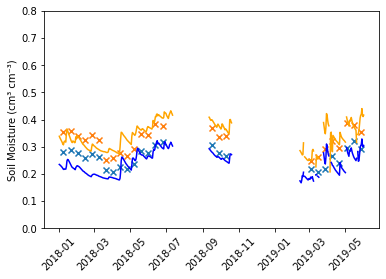

In [108]:
DFtest2 = add_predictions3(DFtest, model, var_in)
DFtest2 = DFtest2.set_index(pd.to_datetime(DFtest2['date']))

plot_series(statio2[30])
plt.scatter(DFtest2.index, DFtest2['pred1'], marker='x')
plt.scatter(DFtest2.index, DFtest2['pred2'], marker='x')
plt.ylabel('Soil Moisture (cm³ cm⁻³)')
plt.ylim(0, 0.8)
plt.tick_params(axis='x', rotation=45)
plt.show()